# OpenAI Baselines

This notebook runs the OpenAI model baselines on the Only Connect dataset.

In [ ]:
# %pip install -r requirements.txt
import json
import os
import re
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from evaluate_only_connect import Evaluate

import guidance
from datasets import load_dataset

## Setup

First, you will need to add your OpenAI API key

In [2]:
os.environ["OPENAI_API_KEY"] = ""

Next, download a copy of the Only Connect dataset from [here](https://drive.google.com/drive/folders/1118w_ydBSBWUru5cPlyGY9TMrgd993f3?usp=sharing). We expect the three JSON files exist under `./dataset`.

In [ ]:
print(f'Found train set: {Path("./dataset/train.json").exists()}')
print(f'Found validation set: {Path("./dataset/validation.json").exists()}')
print(f'Found test set: {Path("./dataset/test.json").exists()}')

Then, load the dataset using the [HuggingFace Datasets Library](https://huggingface.co/docs/datasets/index).

In [ ]:
dataset = load_dataset(
    "json",
    data_files={
        "train": "dataset/train.json",
        "validation": "dataset/validation.json",
        "test": "dataset/test.json",
    },
    field="dataset",
)

Finally, load the helper function with will make the calls to the OpenAI API

In [10]:
def run_openai(
    dataset,
    task: str = "task1",
    model: str = "gpt-3.5-turbo",
    split: str = "test",
    num_in_context_examples: int = 3,
    dry_run: bool = False,
    seed: int = 42,
    **kwargs,
):
    guidance.llm = guidance.llms.OpenAI(model)

    if task == "task1":
        prompt = guidance(
            """{{#system~}}You are currently competing in Round 3: Connecting Wall on the quiz show Only Connect. Your task: given 16 "clues" (words or phrases), solve the wall by grouping the clues into four groups of four. You will be given the clues as a list. You are also given examples of solved walls, which include the connections. Provide your answer as a list of four groups of four clues; separate groups by newlines and clues by commas. Do not try to guess the connection; only use the clues given and don't make up your own.

Be careful! Connecting Wall is deliberately difficult. The puzzles are designed to include red herrings and to suggest more connections than actually exist. Some clues appear to fit into more than one category. Still, there is only one perfect solution for each wall.
{{~/system}}

{{#user~}}
{{examples}}

Clues: {{#each clues}} {{this}}{{#unless @last}},{{/unless}}{{/each}}
{{~/user}}

Solved wall: 

{{#assistant~}}{{gen 'predicted_groups' temperature=0.0 max_tokens=144}}{{~/assistant}}""",
            **kwargs,
        )
    elif task == "task2":
        prompt = guidance(
            """{{#system~}}You are currently competing in Round 3: Connecting Wall on the quiz show Only Connect. Your task: given 4 groups of 4 "clues" (words or phrases), determine the connection for each group. You will be given the groups as four lists of four. You are also given examples of solved walls, which include the connections. Provide your answer by repeating the four groups and adding it after "Connection:"

Note: Connections might be thematic, linguistic, factual, mathematical and rely on both arcane subject areas and popular culture.                    
{{~/system}}

{{#user~}}
{{examples}}

Groups:
{{#each groups}}{{this}}. Connection:{{#unless @last}}\n{{/unless}}{{/each}}
{{~/user}}

Solved wall: 

{{#assistant~}}{{gen 'predicted_connections' temperature=0.0 max_tokens=144}}{{~/assistant}}""",
            **kwargs,
        )

    # Set the RNG here so repeated calls to this function will return the same results every time
    rng = random.Random(seed)

    predictions = []

    # Create the in-context examples
    ic_examples = ""
    random_examples = rng.sample(dataset["train"]["groups"], k=num_in_context_examples)
    for i, example in enumerate(random_examples):
        ic_examples += f"Example {i+1}\n"
        for group in example.values():
            ic_examples += ", ".join(group["gt_words"]) + f". Connection: {group['gt_connection']}\n"
        ic_examples += "\n"
    ic_examples = ic_examples.strip()

    # Run the model on each wall
    iterator = tqdm(dataset[split], desc=f"Running {model} on {split}") if kwargs.get("silent") else dataset[split]
    for i, wall in enumerate(iterator):
        # Clues have already been shuffled, so we can take them as is
        wall_id, clues = (
            wall["wall_id"],
            wall["words"],
        )
        groups = [", ".join(group["gt_words"]) for group in wall["groups"].values()]
        # Try to parse the model response, but if it fails, just use a random guess
        predicted_groups, predicted_connections = None, None
        if task == "task1":
            response = prompt(examples=ic_examples, clues=clues)
            # Sometimes the model returns more or less than 4 groups, truncate or pad with empty strings
            predicted_groups = response["predicted_groups"].splitlines()[:4]
            predicted_groups += [""] * (4 - len(predicted_groups))
            # Sometimes the model returns more or less than 4 words per group, truncate or pad with empty strings
            predicted_groups = [[word.strip() for word in line.split(",")][:4] for line in predicted_groups]
            predicted_groups = [group + ([""] * (4 - len(group))) for group in predicted_groups]
            # Sometimes, the model returns the connection as part of the group, so we need to remove it
            predicted_groups = [
                [re.sub(r"\. Connection:.*", "", word) for word in group] for group in predicted_groups
            ]
        else:
            response = prompt(examples=ic_examples, groups=groups)
            predicted_connections = [
                re.search(r"Connection:\s*(.*)", connection)
                for connection in response["predicted_connections"].splitlines()
            ]
            predicted_connections = [
                connection.group(1).strip() if connection else "" for connection in predicted_connections
            ]
            # Sometimes the model returns more than 4 connections, so we take the first 4
            predicted_connections = predicted_connections[:4]
            # If the model returns fewer than 4 connections, we pad with empty strings
            predicted_connections += [""] * (4 - len(predicted_connections))

        predictions.append(
            {
                "wall_id": wall_id,
                "predicted_groups": predicted_groups,
                "predicted_connections": predicted_connections,
                "gt_groups": [group["gt_words"] for group in dataset[split][i]["groups"].values()],
                "gt_connections": dataset[split][i]["gt_connections"],
            }
        )
        if dry_run:
            print("--dry-run flag passed. Exiting after one example.")
            break

    return predictions

## Task 1: Solving Walls

To run task 1 (solving the wall), run the following:

In [11]:
# Remove dry-run when you are ready to run the full dataset
predictions = run_openai(dataset, task="task1", split="validation", num_in_context_examples=3, dry_run=True)

Stop program system You are currently competing in Round 3: Connecting Wall on the quiz show Only Connect. Your task: given 16 "clues" (words or phrases), solve the wall by grouping the clues into four groups of four. You will be given the clues as a list. You are also given examples of solved walls, which include the connections. Provide your answer as a list of four groups of four clues; separate groups by newlines and clues by commas. Do not try to guess the connection; only use the clues given and don't make up your own.

Be careful! Connecting Wall is deliberately difficult. The puzzles are designed to include red herrings and to suggest more connections than actually exist. Some clues appear to fit into more than one category. Still, there is only one perfect solution for each wall. user Example 1
Autumn, Melancholy, Grecian Urn, Psyche. Connection: Odes by Keats
The Machine, The Magic Roundabout, Nightingale, Michelangelos David. Connection: Florence
The Flumps, Waybuloo, Noggin the Nog, Engie Benjy. Connection: Childrens TV programmes
Woolloomooloo, Bondi Beach, Paddington, The Rocks. Connection: Places in Sydney

Example 2
Agnew, Blofeld, Boycott, Johnston. Connection: Test Match Special regulars
Knees, Bike, Last legs, Marks. Connection: On your ___
Banshees, Tory, Brock, Galore. Connection: Words originating from Irish
Angled, Uppers, Elating, Eighth. Connection: Last letter to front = new word

Example 3
Wedge, Pump, Mule, Brogue. Connection: Types of shoe
Wellington, Sandwich, Plimsoll, Pavlova. Connection: Named after famous people
Custard, Vienna, Snowball, Cookie. Connection: TV cats
Clover, Napoleon, Major, Boxer. Connection: Animal Farm characters 

Clues: Puzzle , Manhattan , B , Wrench , Smith , Nuts , Brooks , Blanc , Suit , Screwdriver , Sidecar , Margarita , Hammer , Business , Gimlet , Gibson Solved wall: assistant Puzzle, Business, Suit, Business
Manhattan, Sidecar, Margarita, Gimlet
Wrench, Smith, Hammer, Screwdriver
Nuts, Brooks, Blanc, Gibson

--dry-run flag passed. Exiting after one example.


To reproduce our results from the paper, run the following

> Note: this can take about ~2 hours per experiement. Results will be cached so re-running the same examples will not result in API calls.

In [ ]:
# model = "gpt-3.5-turbo-0301"
model = "gpt-4-0314"
model_dir = Path(f"baselines/{model}/debug")
model_dir.mkdir(exist_ok=True)
pred_dir = model_dir / "predictions/task1"
pred_dir.parent.mkdir(exist_ok=True)
results_dir = model_dir / "results/task1"
results_dir.parent.mkdir(exist_ok=True)

for num_in_context_examples in [0, 1, 3, 5, 10]:
    predictions = run_openai(
        dataset,
        task="task1",
        model=model,
        split="test",
        num_in_context_examples=num_in_context_examples,
        silent=True,
        stream=False,
        caching=True,
    )

    pred_fp = pred_dir / f"{num_in_context_examples}_in_context_examples.json"
    pred_fp.parent.mkdir(exist_ok=True)
    pred_fp.write_text(json.dumps(predictions, ensure_ascii=False, indent=2))
    results_fp = results_dir / f"{num_in_context_examples}_in_context_examples.json"
    evaluator = Evaluate(str(pred_fp), dataset_path="./dataset/", results_path=str(results_dir), split="test")
    evaluator.task1_grouping_evaluation()

## Task 2: Making Connections

To run task 2 (predicting the connections between solved groups), run the following:

In [12]:
# Remove dry-run when you are ready to run the full dataset
predictions = run_openai(dataset, task="task2", split="validation", num_in_context_examples=3, dry_run=True)

Stop program system You are currently competing in Round 3: Connecting Wall on the quiz show Only Connect. Your task: given 4 groups of 4 "clues" (words or phrases), determine the connection for each group. You will be given the groups as four lists of four. You are also given examples of solved walls, which include the connections. Provide your answer by repeating the four groups and adding it after "Connection:"

Note: Connections might be thematic, linguistic, factual, mathematical and rely on both arcane subject areas and popular culture. user Example 1
Autumn, Melancholy, Grecian Urn, Psyche. Connection: Odes by Keats
The Machine, The Magic Roundabout, Nightingale, Michelangelos David. Connection: Florence
The Flumps, Waybuloo, Noggin the Nog, Engie Benjy. Connection: Childrens TV programmes
Woolloomooloo, Bondi Beach, Paddington, The Rocks. Connection: Places in Sydney

Example 2
Agnew, Blofeld, Boycott, Johnston. Connection: Test Match Special regulars
Knees, Bike, Last legs, Marks. Connection: On your ___
Banshees, Tory, Brock, Galore. Connection: Words originating from Irish
Angled, Uppers, Elating, Eighth. Connection: Last letter to front = new word

Example 3
Wedge, Pump, Mule, Brogue. Connection: Types of shoe
Wellington, Sandwich, Plimsoll, Pavlova. Connection: Named after famous people
Custard, Vienna, Snowball, Cookie. Connection: TV cats
Clover, Napoleon, Major, Boxer. Connection: Animal Farm characters 

Groups:
 Blanc, Brooks, B, Smith . Connection: 
 Screwdriver, Hammer, Gimlet, Wrench . Connection: 
 Sidecar, Manhattan, Gibson, Margarita . Connection: 
 Puzzle, Business, Nuts, Suit . Connection: Solved wall: assistant Blanc, Brooks, B, Smith. Connection: Comedians with the name "B"
Screwdriver, Hammer, Gimlet, Wrench. Connection: Tools and cocktails
Sidecar, Manhattan, Gibson, Margarita. Connection: Types of cocktails
Puzzle, Business, Nuts, Suit. Connection: Words that can be preceded by "Jigsaw"

--dry-run flag passed. Exiting after one example.


To reproduce our results from the paper, run the following

> Note: this can take about ~2 hours per experiement. Results will be cached so re-running the same examples will not result in API calls.

In [ ]:
# model = "gpt-3.5-turbo-0301"
model = "gpt-4-0314"
model_dir = Path(f"baselines/{model}")
model_dir.mkdir(exist_ok=True)
pred_dir = model_dir / "predictions/task2"
pred_dir.parent.mkdir(exist_ok=True)
results_dir = model_dir / "results/task2"
results_dir.parent.mkdir(exist_ok=True)

for num_in_context_examples in [10]:
    predictions = run_openai(
        dataset,
        task="task2",
        model=model,
        split="test",
        num_in_context_examples=num_in_context_examples,
        silent=True,
        stream=False,
        caching=True,
    )

    pred_fp = pred_dir / f"{num_in_context_examples}_in_context_examples.json"
    pred_fp.parent.mkdir(exist_ok=True)
    pred_fp.write_text(json.dumps(predictions, ensure_ascii=False, indent=2))
    evaluator = Evaluate(str(pred_fp), dataset_path="./dataset/", results_path=str(results_dir), split="test")
    evaluator.task2_connections_evaluation()

## Plotting the results

Re-generate plots from the paper

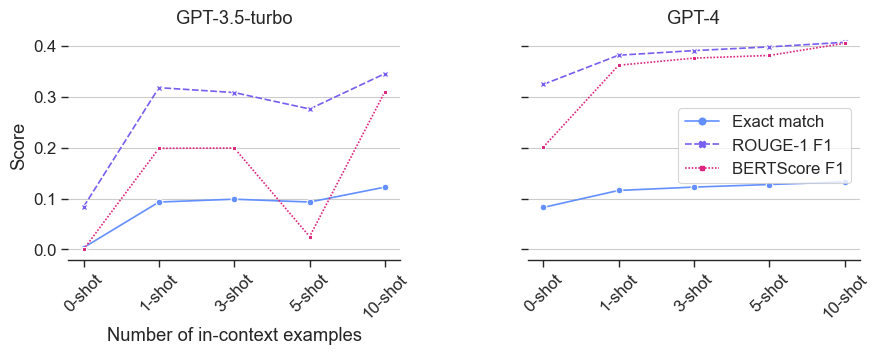

In [176]:
# pip install seaborn
import pandas as pd
import seaborn as sns

# From: https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
palette = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
sns.set_theme(context="paper", style="ticks", palette=palette, font_scale=1.375)

# Loop over all json files in the results directory using Pathlib
df = {"num_in_context_examples": [], "scores": [], "metric": [], "model": []}

for model in ["gpt-4-0314", "gpt-3.5-turbo-0301"]:
    iterator = Path(f"baselines/{model}/results/task2").glob("*.json")
    iterator = sorted(iterator, key=lambda x: int(x.stem.split("_")[0]))
    for results_fp in iterator:
        # Record the number of in-context examples
        num_in_context_examples = int(results_fp.stem.split("_")[0])
        # 3 for the three metrics we report
        df["num_in_context_examples"].extend([f"{num_in_context_examples}-shot"] * 3)
        results = json.loads(results_fp.read_text().strip())["global"]
        # Exact match
        df["scores"].append(results["exact_match"])
        df["metric"].append("Exact match")
        # ROUGE-1 F1
        df["scores"].append(results["rouge1_f1"])
        df["metric"].append("ROUGE-1 F1")
        # BERTScore F1
        df["scores"].append(max(results["bert_score_f1"], 0))
        df["metric"].append("BERTScore F1")
        # Record model name
        model_name = "GPT-3.5-turbo" if model == "gpt-3.5-turbo-0301" else "GPT-4"
        df["model"].extend([model_name] * 3)

df = pd.DataFrame(df)

# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, sharey="row", figsize=(9, 3.75))

for i, model in enumerate(["GPT-3.5-turbo", "GPT-4"]):
    g = sns.lineplot(
        df[df["model"] == model],
        x="num_in_context_examples",
        y="scores",
        hue="metric",
        style="metric",
        markers=True,
        ax=axes[i]
    )
    g.set(xlabel="", ylabel="", title=model)
    

# Set the x and y labels
axes[0].set_xlabel("Number of in-context examples")
axes[0].set_ylabel("Score")
axes[0].legend_ = None
# Move legend to top left of axes[0]
axes[1].legend(loc="center right")
# Set x-axis tick labels to 45 degrees
for ax in axes:
    ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="x", rotation=45)
    ax.yaxis.grid(True)

# Additional global styling
sns.despine(left=True)

# Save a high-resolution version of the plot
fig.tight_layout(w_pad=6)
plt.savefig("baselines/task2_gpt_results.pdf", dpi=500, facecolor="white", bbox_inches="tight")

## Error analysis

Compute several statistics that we reported in the paper.

Compute the fraction of groups with misformatted or hallucinated groups (task 1)

In [160]:
misformatted = 0
hallucinated = 0
# Choose the best performing model
examples = json.loads(Path("baselines/gpt-4-0314/predictions/task1/1_in_context_examples.json").read_text().strip())
for example in examples:
    pred_words = [word for group in example["predicted_groups"] for word in group]
    gt_words = [word for group in example["gt_groups"] for word in group]
    misformatted += pred_words.count("")
    hallucinated += len([word for word in pred_words if word not in gt_words])
# Thi is a proportion of # of groups with an error, as a single error gets counted as 1 wrong group
print(f"Misformatted: {misformatted}/{len(examples)*4} ({misformatted/(len(examples)*4):.2%})")
print(f"Hallucinated: {hallucinated}/{len(examples)*4} ({hallucinated/(len(examples)*4):.2%})")

Misformatted: 120/1976 (6.07%)
Hallucinated: 159/1976 (8.05%)


Compute the fraction of groups which contain the clues in (task 2)

In [169]:
included_clues = 0
# Choose the best performing model
examples = json.loads(Path("baselines/gpt-4-0314/predictions/task2/10_in_context_examples.json").read_text().strip())
for example in examples:
    included_clues += sum(bool(re.search(r'\(.*\)$', connection)) for connection in example["predicted_connections"])
print(f"Included clues: {included_clues}/{len(examples)*4} ({included_clues/(len(examples)*4):.2%})")
     

Included clues: 162/1976 (8.20%)


Compute Human performance for task 2

In [163]:
# Human performance
connections_solved = [sum(item["connections"]) for item in dataset["test"]["overall_human_performance"]]
solve_rate = sum(connections_solved) / (len(connections_solved) * 4)
print(f"Human performance on Task 2: {solve_rate:.2%}")

Human performance on Task 2: 80.47%
